In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV

from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# Dữ liệu

In [2]:
RICE_QUANTITY_URI = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/CaPhe/gia_cafe_xuat_khau_den_2023.csv"

In [3]:
var_file_name = 'arimax_gia_nang_xuat.joblib'
varma_file_name = 'arimax_gia_lua_xang.joblib'


## VAR MODEL

Mô hình VAR (vector autoregressive models) được sử dụng cho chuỗi thời gian đa biến. Cấu trúc của nó là mỗi biến là một hàm tuyến tính của các lag của chính nó và các lag của các biến khác

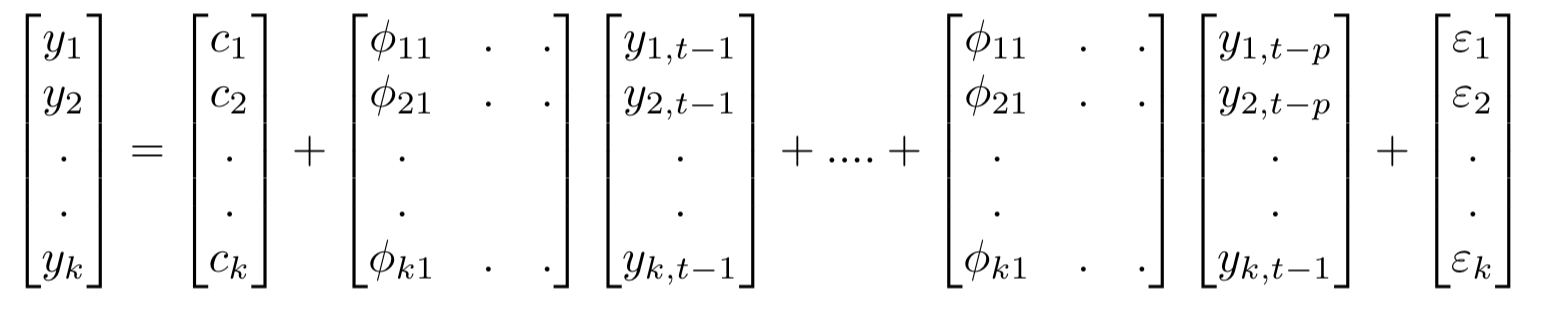

In [4]:
df = pd.read_csv(RICE_QUANTITY_URI)

In [5]:
df.set_index('date', inplace=True)

In [6]:
df.head()

,price,Trieu USD/ Nghin tan
date,,
2009-01-01,24000.0,1.535102
2009-01-02,24500.0,1.535102
2009-01-03,24500.0,1.535102
2009-01-04,24500.0,1.535102
2009-01-05,25000.0,1.535102


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5478 entries, 2009-01-01 to 2023-12-31
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 5478 non-null   float64
 1   Trieu USD/ Nghin tan  5478 non-null   float64
dtypes: float64(2)
memory usage: 128.4+ KB


<Axes: >

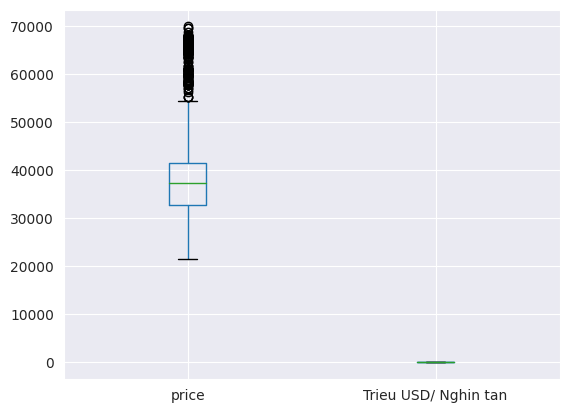

In [8]:
df.boxplot()

In [9]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df.at[df.index[0], 'price'] = min(max(df.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df.index[previous_date_index]
        previous_value = df.loc[previous_date, 'price']
        df.at[index, 'price'] = previous_value

Số lượng outlier: 233


<Axes: >

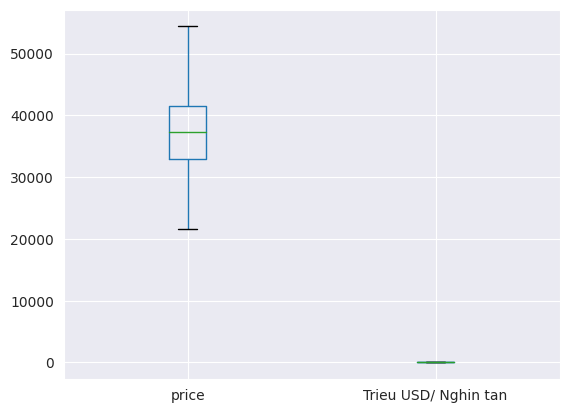

In [10]:
df.boxplot()

In [11]:
df = df.dropna()

In [12]:
df_corr = df.copy()

In [13]:
# Find the pearson correlations matrix
corr = df_corr.corr(method = 'pearson')
corr

,price,Trieu USD/ Nghin tan
price,1.000000,0.952581
Trieu USD/ Nghin tan,0.952581,1.000000


In [14]:
df = df_corr

In [15]:
df = df.rename(columns={'Trieu USD/ Nghin tan': 'xuat_khau'})

In [16]:
fillter_feature = ['price', 'xuat_khau']
df = df[fillter_feature]

In [17]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,xuat_khau
price,1.000000,0.952581
xuat_khau,0.952581,1.000000


<Axes: xlabel='date'>

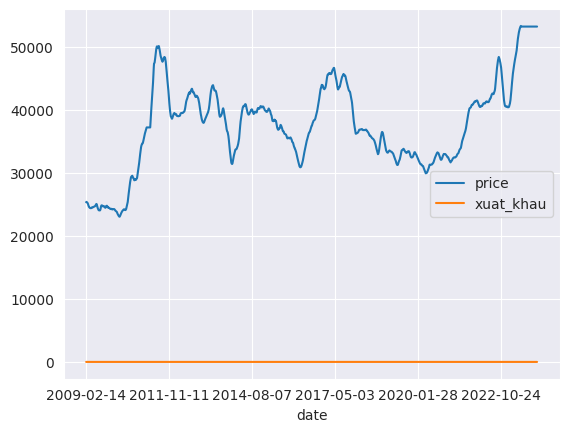

In [18]:
df.price = df.price.rolling(45).mean()
df = df.dropna()
df.plot()

In [19]:
nobs = int(len(df) * 0.8)
df_train, df_test = df[0:nobs], df[nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(4347, 2)
(1087, 2)


In [20]:
from google.colab import files


## Kiểm tra stationary

In [21]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [22]:
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7331
 No. Lags Chosen       = 4
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0685. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "xuat_khau" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.437
 No. Lags Chosen       = 31
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.1316. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




In [23]:
# df_differenced = np.log(df_train)
# df_differenced = df_differenced.dropna()
# df_differenced = df_differenced[1:]

In [24]:
df_differenced = df_train.diff().dropna()

In [25]:
df_differenced

,price,xuat_khau
date,,
2009-02-15,20.000000,0.0
2009-02-16,6.666667,0.0
2009-02-17,17.777778,0.0
2009-02-18,11.111111,0.0
2009-02-19,-11.111111,0.0
...,...,...
2021-01-04,-4.444444,0.0
2021-01-05,-8.888889,0.0
2021-01-06,-11.111111,0.0


In [26]:
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.6012
 No. Lags Chosen       = 3
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "xuat_khau" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.8965
 No. Lags Chosen       = 30
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




<Axes: xlabel='date'>

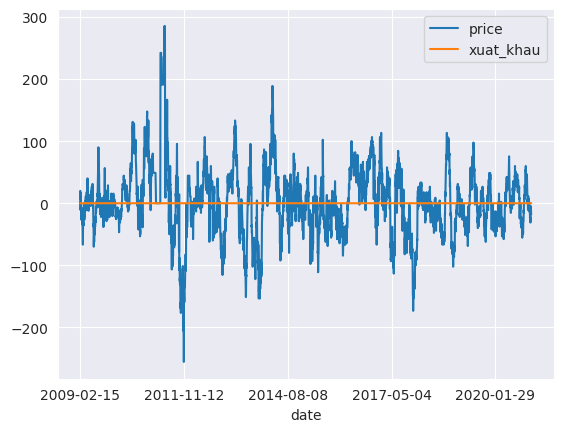

In [27]:
df_differenced.plot()

## Train model

### Đánh giá mô hình VAR

In [28]:
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_absolute_percentage_error
def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast) * 100 # MAPE

    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    return({'mape':mape,'rmse':rmse})

In [29]:
columns_train = fillter_feature

In [30]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.1 MB/s eta 0:00:00


In [31]:
from pmdarima import auto_arima

In [32]:
arimax = auto_arima(df_differenced.price, exogenous = df_differenced[[ 'xuat_khau']],
           start_p=3,
           start_q=3,
           max_p=7,
           max_q=7,
            seasonal=False,
          trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=49.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35090.750, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=35079.402, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=35078.175, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35088.752, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=35075.471, Time=1.95 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=35074.369, Time=0.83 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=35072.820, Time=0.61 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=35074.349, Time=0.70 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=35076.364, Time=0.83 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=35070.822, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=35077.403, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=35072.351, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=35072.370, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] 

In [33]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_forecast'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [34]:
# Forecast
n_periods = len(df_test)
fitted, confint = arimax.predict(n_periods=n_periods,
                                  exogenous=[ 'area'],
                                  return_conf_int=True)


In [35]:
np.square(fitted)

2021-01-09    304.567729
2021-01-10    301.787128
2021-01-11    302.450841
2021-01-12    302.535788
2021-01-13    302.501378
                 ...    
2023-12-27    302.501147
2023-12-28    302.501147
2023-12-29    302.501147
2023-12-30    302.501147
2023-12-31    302.501147
Freq: D, Length: 1087, dtype: float64

In [36]:
df_test.index

Index(['2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12', '2021-01-13',
       '2021-01-14', '2021-01-15', '2021-01-16', '2021-01-17', '2021-01-18',
       ...
       '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25', '2023-12-26',
       '2023-12-27', '2023-12-28', '2023-12-29', '2023-12-30', '2023-12-31'],
      dtype='object', name='date', length=1087)

In [37]:
fc_series = pd.DataFrame({'price': fitted.values}, index = df_test.index)

In [38]:
fc_series

,price
date,
2021-01-09,-17.451869
2021-01-10,-17.372021
2021-01-11,-17.391114
2021-01-12,-17.393556
2021-01-13,-17.392567
...,...
2023-12-27,-17.392560
2023-12-28,-17.392560
2023-12-29,-17.392560


<Axes: xlabel='date'>

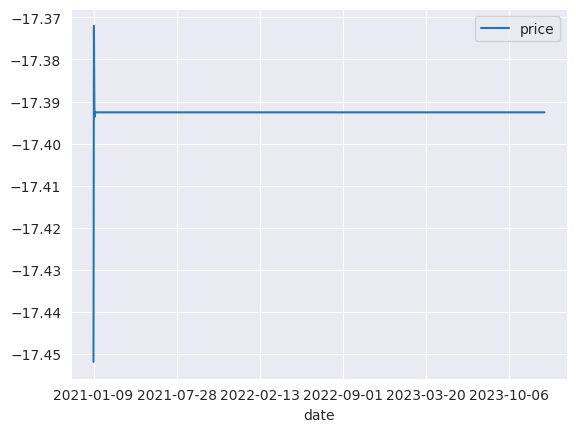

In [39]:
fc_series.plot()

In [40]:
fc_series.price = df_test.price.iloc[0] + fc_series.price.cumsum()

<Axes: xlabel='date'>

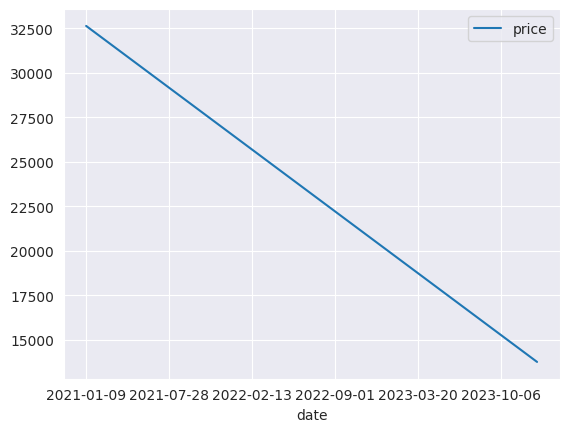

In [41]:
fc_series.plot()

Đánh giá mô hình

In [42]:
accuracy_prod = forecast_accuracy(fc_series['price'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

mape :  42.538
rmse :  23122.4397


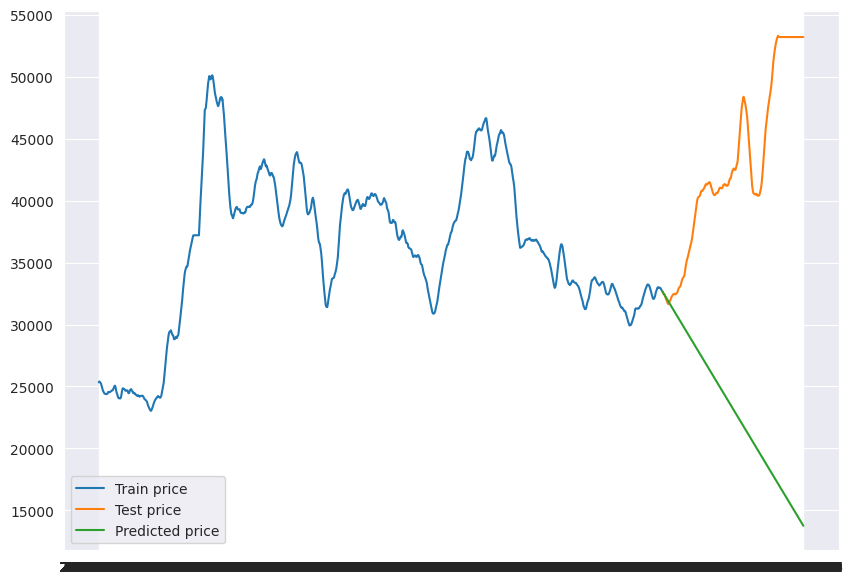

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['price']:

    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(df_train[str(i)], label='Train '+str(i))
    plt.plot(df_test[str(i)], label='Test '+str(i))
    plt.plot(fc_series[str(i)], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

In [44]:
import joblib
joblib.dump(arimax, varma_file_name)
from google.colab import files
files.download(varma_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>